# Importing Packages

In [8]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import imageio
import re

# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import warnings
warnings.simplefilter("ignore")
from glob import glob
import cv2

import tensorflow as tf
from keras import Sequential, Model
from keras.models import load_model, save_model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, MaxPooling2D, AveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121
from keras.metrics import AUC, Precision, Recall

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import albumentations as A
import random

from utils import *

%reload_ext autoreload
%autoreload 2

# Exploratory Data Analysis

In [3]:
# folder path
non_TB_path_train = r'data/augmented_sorted/train/Non-TB/'
non_TB_path_test = r'data/augmented_sorted/test/Non-TB/'
non_TB_path_val = r'data/augmented_sorted/val/Non-TB/'

TB_path_train = r'data/augmented_sorted/train/TB/'
TB_path_test = r'data/augmented_sorted/test/TB/'
TB_path_val = r'data/augmented_sorted/val/TB/'

count = 0
# Iterate directory
non_TB_path = [non_TB_path_train, non_TB_path_test, non_TB_path_val]
TB_path = [TB_path_train, TB_path_test, TB_path_val]

for path in non_TB_path:
    for file in os.listdir(path):
    # check if current path is a file
        if os.path.isfile(os.path.join(path, file)):
            count += 1
non_tb_images=count
print('Total Non-TB images:', non_tb_images)

count=0
for path in TB_path:
    for file in os.listdir(path):
    # check if current path is a file
        if os.path.isfile(os.path.join(path, file)):
            count += 1
tb_images=count
print('Augmented and Original TB images:', tb_images)

count = 0
for root_dir, cur_dir, files in os.walk(r'data/augmented_sorted/train/'):
    count += len(files)
train_images = count
print('Training Set:', train_images)

count = 0
for root_dir, cur_dir, files in os.walk(r'data/augmented_sorted/val/'):
    count += len(files)
val_images = count
print('Validation Set:', val_images)

count = 0
for root_dir, cur_dir, files in os.walk(r'data/augmented_sorted/test/'):
    count += len(files)
test_images = count
print('Testing Set:', test_images)

Total Non-TB images: 7993
Augmented and Original TB images: 4207
Training Set: 10134
Validation Set: 1031
Testing Set: 1035


## Distribution of Target Variable

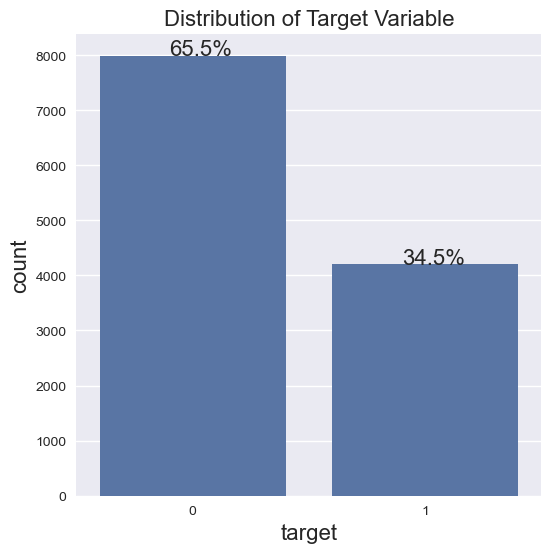

In [6]:
ntb_list = os.listdir(non_TB_path_train) + os.listdir(non_TB_path_val) + os.listdir(non_TB_path_test)
tb_list = os.listdir(TB_path_train) + os.listdir(TB_path_val) + os.listdir(TB_path_test)

non_tb_df = pd.DataFrame(ntb_list, columns=['filename'])
non_tb_df['target'] = 0
tb_df = pd.DataFrame(tb_list, columns=['filename'])
tb_df['target'] = 1

target_df = pd.concat([tb_df, non_tb_df], axis=0)

plt.style.use("seaborn")

# create visualization for target variable distribution
def barplot(df, xlabel, ylabel, title):
    plt.figure(figsize = (6, 6))
    ax = sns.countplot(x = xlabel, data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    total = len(df.target)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 16)
    plt.show()

barplot(target_df, 'target', 'count', 'Distribution of Target Variable')

## Distribution of NIH Dataset Patients

In [11]:
# create dataframes from the clinical diagnosis files
df_list = []

for f in glob("data/MTG_ClinicalReadings/*.txt", recursive=True):
    data = pd.read_csv(f, sep=':', header=None)
    df_list.append(data)

diagnoses = [x.iloc[2, 0] for x in df_list]
ages = [int(x.iloc[1, 1][2:-1]) for x in df_list]
sex = [x.iloc[0, 1][1: -1] for x in df_list]

nih_mont_df = pd.DataFrame({"Age": ages, "Sex": sex, "Diagnosis": diagnoses,})
nih_mont_df['Source'] = 'Montgomery'

df_list = []

for f in glob("data/SHZ_ClinicalReadings/*.txt", recursive=True):
    data = pd.read_csv(f, sep='\t', header=None)
    df_list.append(data)

diagnoses = [x.iloc[1, 0] for x in df_list]
sex_and_age = [x.iloc[0, 0] for x in df_list]
ages = [int(re.findall('\\d+', text)[0]) for text in sex_and_age]
sex = ['F' if re.search('f', text) else 'M' for text in sex_and_age]

nih_shen_df = pd.DataFrame({"Age": ages, "Sex": sex, "Diagnosis": diagnoses,})
nih_shen_df['Source'] = 'Shenzhen'

diagnosis_df = pd.concat([nih_mont_df, nih_shen_df], axis=0)

normal_df = diagnosis_df.loc[diagnosis_df.Diagnosis=='normal']
tb_df = diagnosis_df.loc[diagnosis_df.Diagnosis!='normal']


Text(0, 0.5, 'Count')

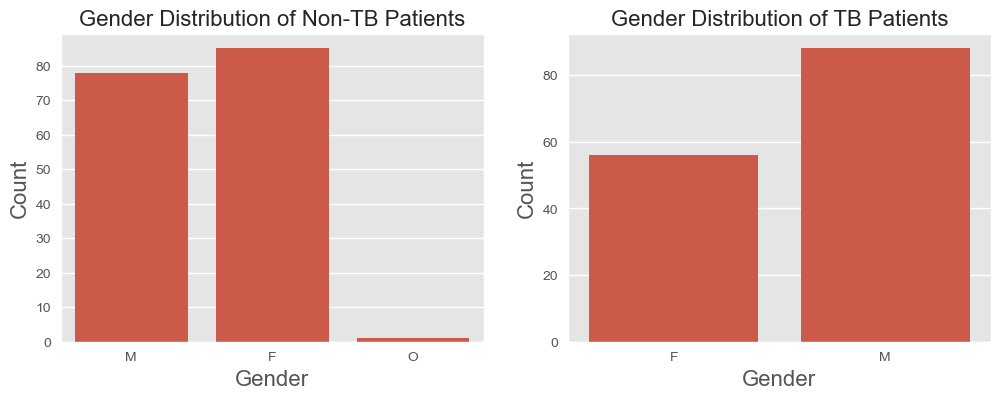

In [12]:
# display difference in gender distribution of TB vs. non-TB patients
plt.style.use('ggplot')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='Sex', data=normal_df, ax=ax1)
b = sns.countplot(x='Sex', data=tb_df, ax=ax2)
ax1.set_title("Gender Distribution of Non-TB Patients", fontsize=16)
ax2.set_title("Gender Distribution of TB Patients", fontsize=16)
ax1.set_xlabel('Gender', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Gender', size=16)
ax2.set_ylabel('Count', size=16)

Text(0, 0.5, 'Count')

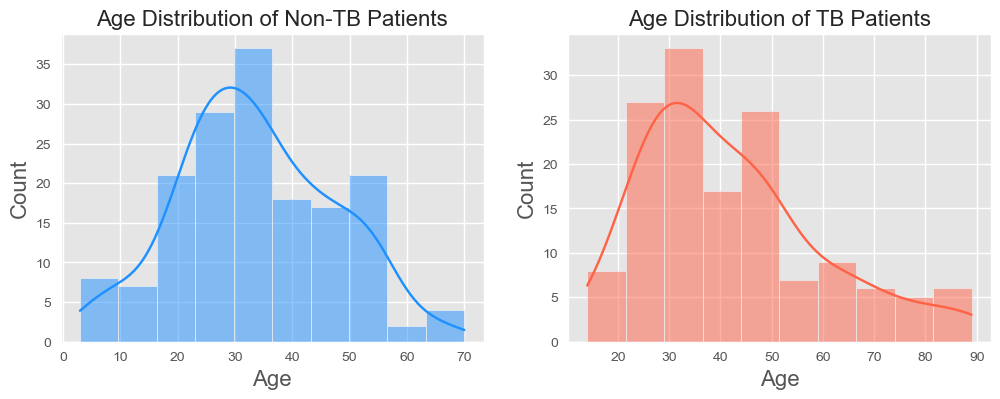

In [13]:
# create graphs to display distribution of age for non-TB vs. TB patients
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='Age', data=normal_df, kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='Age', data=tb_df, kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Non-TB Patients", fontsize=16)
ax2.set_title("Age Distribution of TB Patients", fontsize=16)
ax1.set_xlabel('Age', size=16)
ax1.set_ylabel('Count', size=16)
ax2.set_xlabel('Age', size=16)
ax2.set_ylabel('Count', size=16)

## Non-Tuberculosis Images

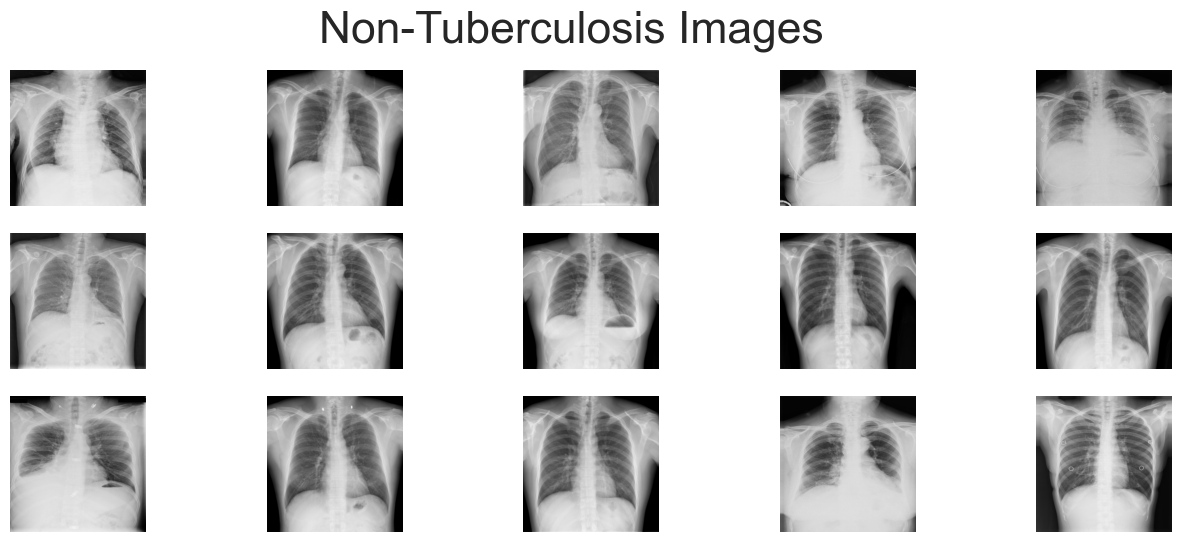

In [15]:
# display sample of non-TB images
plt.style.use('seaborn')
paths = glob('data/augmented_sorted/train/Non-TB/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Non-Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

## Tuberculosis Images

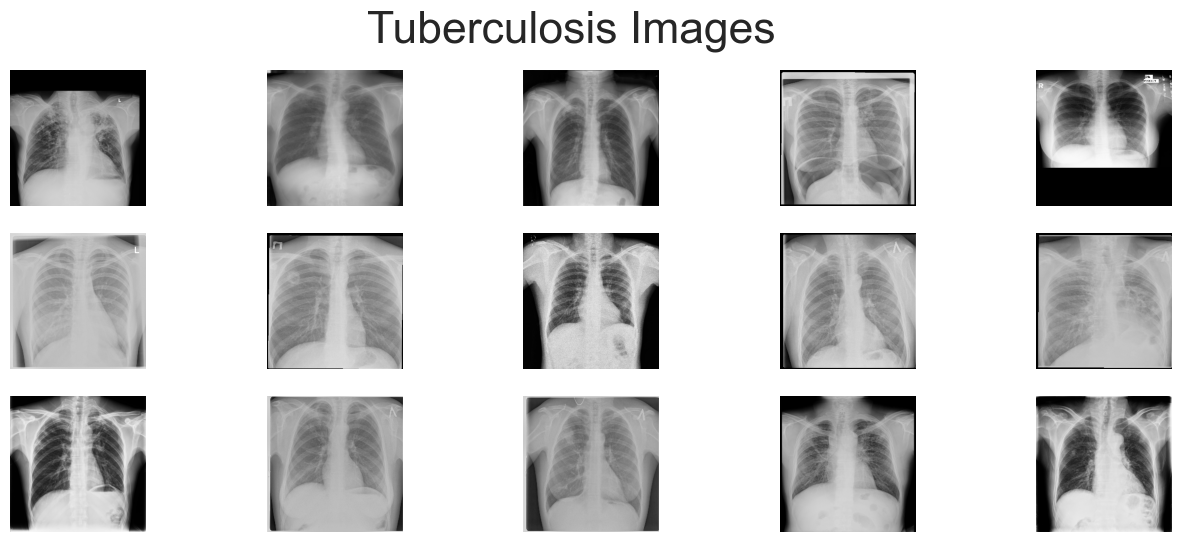

In [17]:
# display sample of TB images
plt.style.use('seaborn')
paths = glob('data/augmented_sorted/val/TB/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

## Tuberculosis Images Augmented with Albumentations

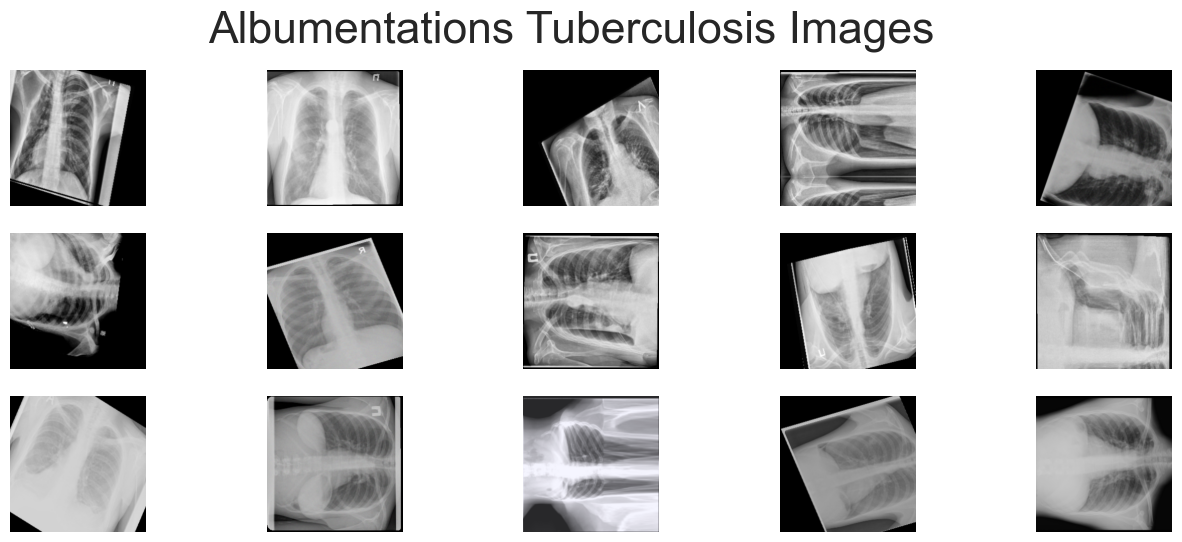

In [18]:
# display sample of TB images
plt.style.use('seaborn')
paths = glob('data/augmentations/*.png')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 6))
plt.suptitle('Albumentations Tuberculosis Images', fontsize=32)
for i in range(0, 15):
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image)
    axes[x, y].axis('off')

# Data Preprocessing

In [2]:
# defining parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
INIT_LR = 0.001
EPOCHS = 20

# Set path for training testing and validation
# Data Generator for training, validation, and testing

folder = 'data/augmented_sorted'

# assigning paths
src_path_train = os.path.join(folder, 'train/')
src_path_val = os.path.join(folder, "val/")
src_path_test = os.path.join(folder,  'test/')

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        src_path_train,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle = True,
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        src_path_val,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle = True,
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        src_path_test,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = 1,
        class_mode = None,
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 10134 images belonging to 2 classes.
Found 1031 images belonging to 2 classes.
Found 1035 images belonging to 2 classes.


In [3]:
# calculate class weights
total_tb = len(os.listdir(os.path.join(src_path_train, 'TB')))
total_healthy = len(os.listdir(os.path.join(src_path_train, 'Non-TB')))

weight_for_0 = total_tb / (total_healthy + total_tb)
weight_for_1 = total_healthy / (total_healthy + total_tb)

class_weights = {0: weight_for_0, 1: weight_for_1}
class_weights

{0: 0.36895598973751725, 1: 0.6310440102624827}

# Modeling

In [4]:
# create model
def build_DenseNet_model():
    baseModel = DenseNet121(weights="imagenet",
                            include_top=False,
                            input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    output = baseModel.output
    output = AveragePooling2D(pool_size=(2, 2))(output)
    output = Flatten(name="flatten")(output)
    output = Dense(512, activation="relu")(output)
    output = Dropout(0.25)(output)
    output = Dense(1, activation="sigmoid")(output)
    model = Model(inputs=baseModel.input, outputs=output)
    for layer in baseModel.layers:
        layer.trainable = False
    return model


model = build_DenseNet_model()

MODEL_NAME = 'DenseNet'
model_path = os.path.join("logs", MODEL_NAME)

try:
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        print("Model Directory Created")
    else:
        files = glob(os.path.join(model_path, "*"))
        for f in files:
            os.remove(f)
        print("Model Directory Already Exists and Files Deleted")
except Exception as e:
    print('Failed to delete %s. Reason: %s' % (model_path, e))


# compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=INIT_LR, decay=INIT_LR / EPOCHS
    ),
    metrics=["accuracy", AUC(), AUC(curve="PR"), Precision(), Recall()],
)

# es = EarlyStopping(monitor = 'val_loss',
    #               verbose = 1,
    #               mode = 'min',
    #               patience = 4),
rlrp = ReduceLROnPlateau(monitor="val_accuracy", 
                      patience=3, 
                      verbose=1, 
                      factor=0.5, 
                      min_lr=0.00001)
mcp = ModelCheckpoint(filepath=os.path.join(model_path, "checkpoints/model_{epoch:02d}_{val_loss:.2f}.hdf5"),
                    verbose=1,
                    monitor="val_loss",
                    mode="min")
cl = CSVLogger(os.path.join(model_path, "log.csv"))
tb = TensorBoard(log_dir=os.path.join(model_path, "tb_log"),
                 histogram_freq=1,
                 update_freq="batch")

# train model
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    class_weight = class_weights,
                    callbacks = [rlrp, mcp, cl, tb])


2023-10-13 18:06:58.826487: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-13 18:06:58.826508: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-13 18:06:58.826512: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-13 18:06:58.826723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-13 18:06:58.826924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model Directory Created
Epoch 1/20


2023-10-13 18:07:03.540899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


316/316 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.8348 - auc: 0.8746 - auc_1: 0.7749 - precision: 0.7444 - recall: 0.8402

2023-10-13 18:09:51.307264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to logs/DenseNet/checkpoints/model_01)_0.32.hdf5
316/316 [==============================] - 192s 596ms/step - loss: 0.9982 - accuracy: 0.8348 - auc: 0.8746 - auc_1: 0.7749 - precision: 0.7444 - recall: 0.8402 - val_loss: 0.3186 - val_accuracy: 0.9316 - val_auc: 0.9461 - val_auc_1: 0.8585 - val_precision: 0.8515 - val_recall: 0.8442 - lr: 0.0010
Epoch 2/20
316/316 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9055 - auc: 0.9569 - auc_1: 0.9239 - precision: 0.8496 - recall: 0.9037
Epoch 2: saving model to logs/DenseNet/checkpoints/model_02)_0.27.hdf5
316/316 [==============================] - 188s 592ms/step - loss: 0.1823 - accuracy: 0.9055 - auc: 0.9569 - auc_1: 0.9239 - precision: 0.8496 - recall: 0.9037 - val_loss: 0.2713 - val_accuracy: 0.9277 - val_auc: 0.9787 - val_auc_1: 0.9161 - val_precision: 0.7782 - val_recall: 0.9526 - lr: 0.0010
Epoch 3/20
316/316 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9313 - 

In [5]:
model.save(os.path.join(model_path, "DenseNet-model.keras"))
model.save_weights(os.path.join(model_path, "DenseNet-weights.h5"))


In [6]:
history = pd.read_csv(os.path.join(model_path, "log.csv"))
history

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.834785,0.874571,0.774943,0.998221,0.001000,0.744407,0.840183,0.931641,0.946133,0.858463,0.318602,0.851528,0.844156
1,1,0.905464,0.956870,0.923935,0.182272,0.001000,0.849609,0.903650,0.927734,0.978729,0.916116,0.271259,0.778169,0.952586
2,2,0.931301,0.972213,0.951456,0.128164,0.001000,0.889432,0.929089,0.938477,0.967702,0.937195,0.236617,0.956757,0.762931
3,3,0.940705,0.979617,0.963912,0.100740,0.001000,0.905070,0.937818,0.777344,0.956920,0.788815,0.909834,0.501099,0.995633
4,4,0.939220,0.981161,0.968577,0.095726,0.001000,0.902426,0.936763,0.960938,0.977363,0.940910,0.155773,0.936652,0.888412
5,5,0.943972,0.983339,0.968896,0.087041,0.001000,0.907565,0.944131,0.949219,0.972100,0.951520,0.200297,0.959391,0.811159
6,6,0.949218,0.984907,0.974114,0.083285,0.001000,0.917120,0.948313,0.959961,0.973688,0.938777,0.168559,0.939815,0.878788
7,7,0.961295,0.989887,0.982177,0.061591,0.001000,0.937156,0.959517,0.949219,0.985706,0.943839,0.198291,0.838346,0.961207
8,8,0.967630,0.992837,0.986925,0.047072,0.000500,0.947604,0.965656,0.947266,0.985782,0.943981,0.198577,0.837121,0.952586
9,9,0.968323,0.992839,0.986457,0.048871,0.000500,0.948199,0.967015,0.958984,0.976027,0.954386,0.158129,0.935185,0.878261


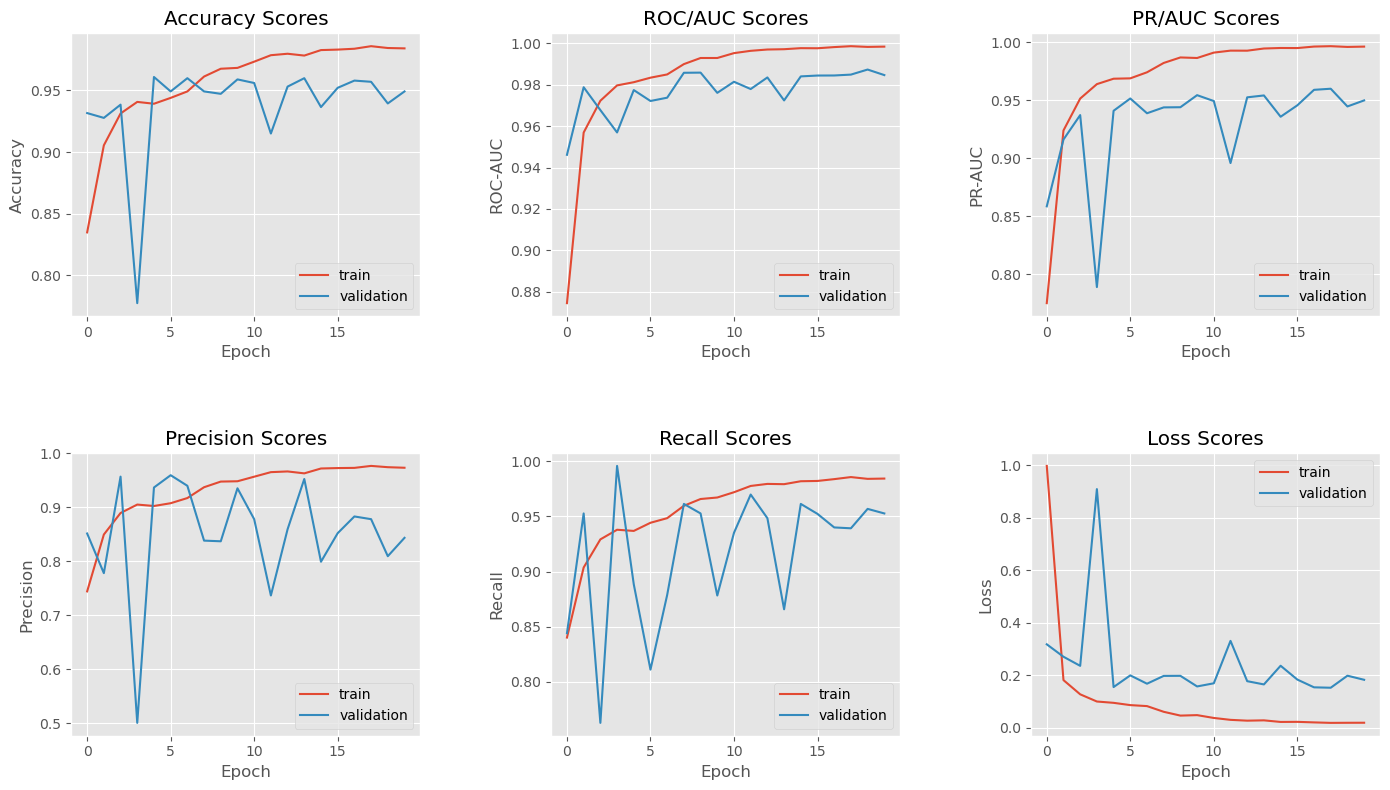

In [16]:
model = tf.keras.models.load_model(os.path.join(model_path, 'checkpoints/model_20_0.18.hdf5'))

# evaluate model by displaying metrics with visualization
plt.style.use('ggplot')
sixplot2(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [17]:
score = model.evaluate_generator(generator=valid_generator,
                                 steps=STEP_SIZE_VALID)

print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))
print("Validation Precision: " + str(score[2]))
print("Validation Recall: " + str(score[3]))
print("Validation ROC-AUC: " + str(score[4]))
print("Validation PR-AUC: " + str(score[5]))

2023-10-13 20:17:41.328535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Validation Loss: 0.18830911815166473
Validation Accuracy: 0.9482421875
Validation Precision: 0.9843391180038452
Validation Recall: 0.9487156867980957
Validation ROC-AUC: 0.8390804529190063
Validation PR-AUC: 0.9521738886833191


2023-10-13 20:18:12.503068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1035/1035 [==============================] - 48s 44ms/step


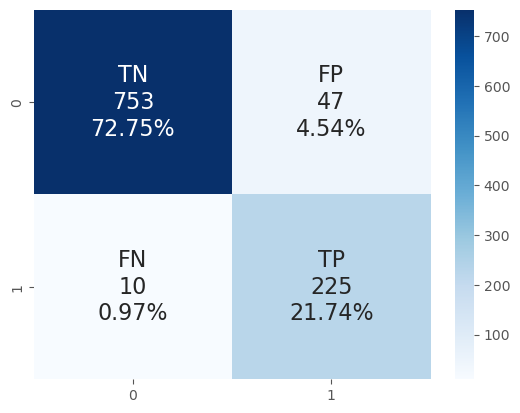

In [18]:
# get testing accuracy and loss
test_generator.reset()
# display confusion matrix visualization
pred = model.predict_generator(test_generator, 
                               steps = STEP_SIZE_TEST, 
                               verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)